In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from math import *
import imageio
from scipy import ndimage, misc
from skimage import morphology
import skimage.measure as measure
import skimage.segmentation as segmentation
import skimage as sk

folder = '/home/edo20/PIV'

In [2]:
# Experimental data

# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
image_number = '013'

In [3]:
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' + image_number + 'b.tif' )

In [4]:
def doubleplot(frame_a,frame_b):
    ax = plt.subplot(121)
    ax.imshow(frame_a)
    ax.set_title('Frame a')
    ax2 = plt.subplot(122)
    ax2.imshow(frame_b)
    ax2.set_title('Frame b')


# Image binarization

In [5]:
bin_a = frame_a > 250
bin_b = frame_b > 250

bin_a = bin_a.astype('uint8')
bin_b = bin_b.astype('uint8')

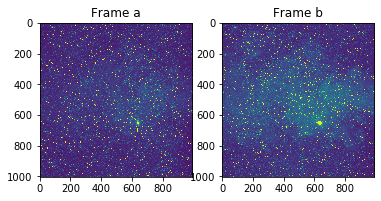

In [6]:
# Set default colormap
# plt.set_cmap(plt.cm.gray)
doubleplot(frame_a, frame_b)

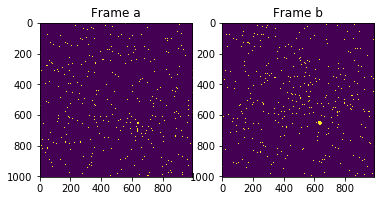

In [7]:
doubleplot(bin_a,bin_b)

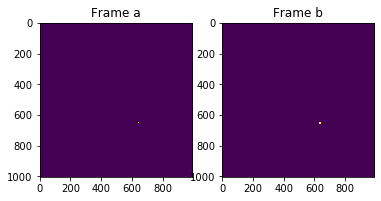

In [8]:
# Erosion to find the "big" regions where brightness is high, element= cross

kernel_size = 5
kernel = np.ones((kernel_size,kernel_size))
iterations = 3

temp_a, temp_b = bin_a, bin_b
for i in range(0,iterations):
    temp_a = morphology.erosion(temp_a)
    temp_b = morphology.erosion(temp_b)

flash_a = temp_a
flash_b = temp_b

doubleplot(flash_a, flash_b)

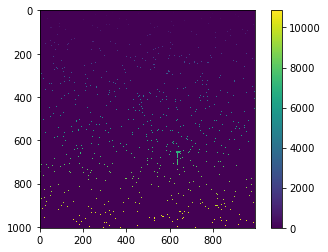

In [9]:
labeled_a = measure.label(bin_a)


plt.imshow(labeled_a)
plt.colorbar()

In [10]:
regions_a = measure.regionprops(labeled_a)

In [11]:
# for i in range(0, max(labeled_a)):
#        if np.any( np.logical_and(flash_a*i == labeled_a, flash_a == 1)):
#            flashindex = i

In [12]:
# np.any( np.logical_and(flash_a*i == labeled_a, flash_a == 1))

(array([646]), array([939]))
7107.0


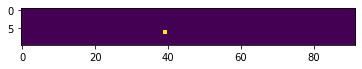

In [13]:
npunti = np.sum(flash_a)
region_label = np.sum(np.multiply(labeled_a,flash_a))/npunti
# region_flash = labeled_a == region_label
region_flash = labeled_a - region_label
#region_flash = np.equal(region_flash, np.zeros(np.shape(labeled_a)))
pippo = region_flash == np.zeros(np.shape(region_flash))
plt.imsave('pippo.png',pippo)
pippo2 = pippo[640:650,900:1000]
plt.imshow(pippo2)
print(np.nonzero(pippo))
# plt.colorbar()
print(region_label)

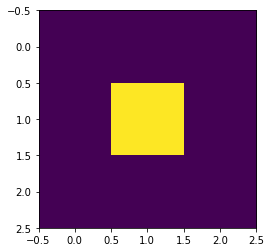

In [14]:
A = np.asarray([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
# B = np.ones((3,3))
B = 4
C = A == B
plt.imshow(C)

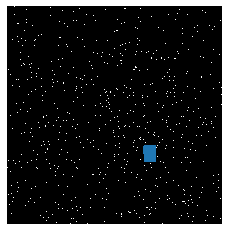

In [15]:
frame_a = bin_a
tresh = sk.filters.threshold_otsu(frame_a)
bw = sk.morphology.closing(frame_a > tresh, sk.morphology.square(3))
cleared = sk.segmentation.clear_border(bw)
labele_image = sk.measure.label(cleared)

ax = plt.axes()
ax.imshow(frame_a, cmap=plt.cm.gray)

for region in sk.measure.regionprops(labele_image):
    if region.area >= 100:
        AAAAAAAAAAAAAAAAAAAAA = region
        maxr,minr,maxc,minc = region.bbox
        A = (minr, minc)
        B = (maxr, maxc)
        width = maxr-minr
        height= maxc-minc
        rect = matplotlib.patches.Rectangle( [minr, minc], width, 
                                            height)
        ax.add_patch(rect)

ax.set_axis_off()
plt.savefig('name', dpi = 1000)